# Fig 1

These are the cells that we use to make Fig. 1. I will try (but probably fail) to note the notebooks where they come from!

### Generic imports and read the data.

This is the same!

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


### Read the data

In [3]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


### Read the autoencoder data

In [4]:
encoder_models = 'cluster_gbrfs'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

## Fig 1 a,b,c

These sections come from the [Pseudomonas notebook](Pseudomonas.ipynb)

### Run the GBRF for Pseudomonas

We used 349 estimators for the random forest classifier


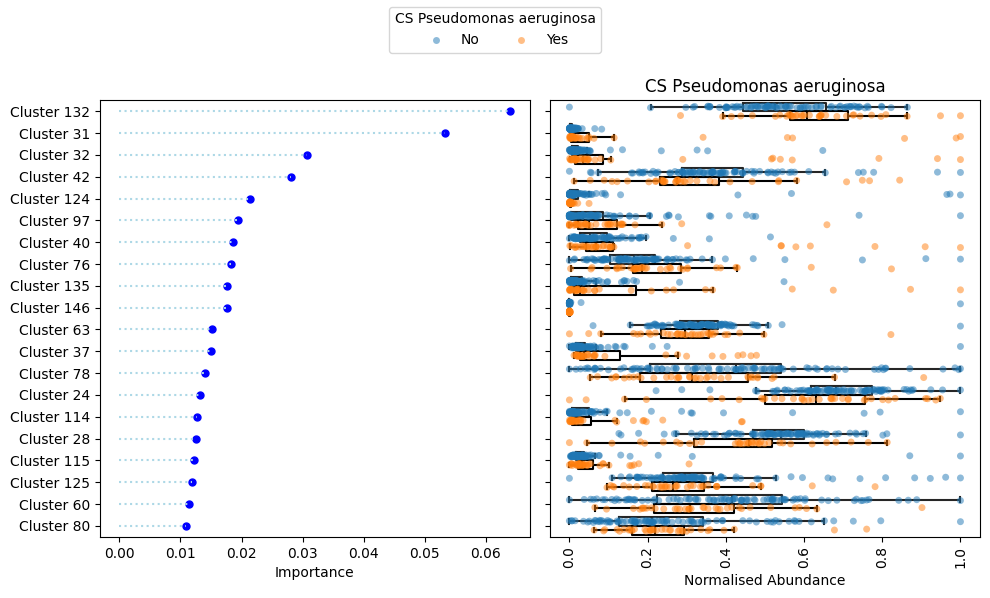

In [5]:
#intcol = 'Pseudomonas Culture' # note these two columns have the same information, but 'CS_Pseudomonas aeruginosa' is a category, while 'Pseudomonas culture' is a float!
intcol = 'CS_Pseudomonas aeruginosa'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, custom_labels, savepng = 'final_images/cluster_importance.png')

### Create the ROC curve (Fig 1c)

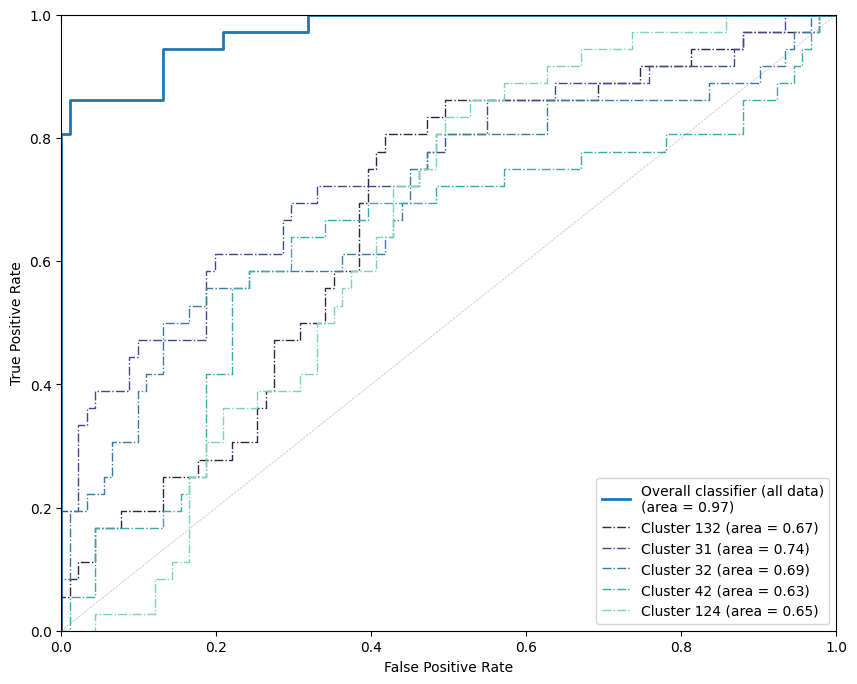

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title, ax=ax)
ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, "", ax=ax)
plt.savefig('final_images/pseudomonas_roc_curve.png')
plt.show()

## Fig 1 d

These parts come from the 